In [72]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import grad
import torch.nn.functional as F

In [73]:
df = pd.read_csv('iris.data', index_col = None, header = None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
df.tail()

,x1,x2,x3,x4,y
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1
149,5.9,3.0,5.1,1.8,1


In [131]:
X = torch.tensor(df[['x1','x2','x3','x4']].values, dtype = torch.float)
y = torch.tensor(df['y'].values, dtype = torch.long)

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(y.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

mu, sigma = X_train.mean(dim = 0), X_train.std(dim = 0)
X_train = (X_train - mu)/sigma
X_test = (X_test - mu)/sigma

In [183]:
class MultilayerPercep(torch.nn.Module):
    
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
        super(MultilayerPercep, self).__init__()
        
        self.my_network = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_2, num_classes),
        )
        
    def forward(self, X):
        logits = self.my_network(X)
#         probas = F.softmax(logits, dim=1)
        return logits

In [184]:
# class MultilayerPercep(torch.nn.Module):
    
#     def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
#         super(MultilayerPercep, self).__init__()
        
#         self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
#         self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
#         self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
#     def forward(self, X):
#         out = self.linear_1(X)
#         out = F.relu(out)
#         out = self.linear_2(out)
#         out = F.relu(out)
#         logits = self.linear_out(out)
#         probas = F.softmax(logits, dim=1)
#         return logits, probas

In [185]:
def train(model, X, y, epochs, minibatch_size, seed = 123, learning_rate = 0.01):
    cost_lst = []
    model.train()
    torch.manual_seed(seed)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    for j in range(epochs):
        
        shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        for i in minibatches:
            features = X.size(1)
            # Forward Propagation
            logits = model(X[i])
#             y_train[i] = y_train[i].type(torch.LongTensor)
            cost = F.cross_entropy(logits, y[i])
            # resetting gradients to 0
            optimizer.zero_grad()
            
            # Computes gradient
            cost.backward()
            
            # Updates weights and bias
            optimizer.step()
            
        model.eval()
#         #### Logging ####
        with torch.no_grad():
            # context manager to
            # avoid building graph during "inference"
            # to save memory
            logits = model(X)
            cost = F.cross_entropy(logits, y)
            print('Epoch: %03d' % (j+1), end="")
            print(' | Cross Entropy Error: %.5f' % cost)
            cost_lst.append(cost)
    
    return cost_lst

In [187]:
model = MultilayerPercep(num_features = X_train.size(1), num_classes = 2, num_hidden_1 =10, num_hidden_2 = 10)
cost_lst = train(model, X_train, y_train, epochs = 100, minibatch_size = 10, seed =123, learning_rate = 0.01)

Epoch: 001 | Cross Entropy Error: 0.69840
Epoch: 002 | Cross Entropy Error: 0.69042
Epoch: 003 | Cross Entropy Error: 0.68240
Epoch: 004 | Cross Entropy Error: 0.67455
Epoch: 005 | Cross Entropy Error: 0.66682
Epoch: 006 | Cross Entropy Error: 0.65920
Epoch: 007 | Cross Entropy Error: 0.65169
Epoch: 008 | Cross Entropy Error: 0.64417
Epoch: 009 | Cross Entropy Error: 0.63666
Epoch: 010 | Cross Entropy Error: 0.62926
Epoch: 011 | Cross Entropy Error: 0.62189
Epoch: 012 | Cross Entropy Error: 0.61457
Epoch: 013 | Cross Entropy Error: 0.60744
Epoch: 014 | Cross Entropy Error: 0.60052
Epoch: 015 | Cross Entropy Error: 0.59370
Epoch: 016 | Cross Entropy Error: 0.58703
Epoch: 017 | Cross Entropy Error: 0.58056
Epoch: 018 | Cross Entropy Error: 0.57424
Epoch: 019 | Cross Entropy Error: 0.56809
Epoch: 020 | Cross Entropy Error: 0.56200
Epoch: 021 | Cross Entropy Error: 0.55607
Epoch: 022 | Cross Entropy Error: 0.55035
Epoch: 023 | Cross Entropy Error: 0.54470
Epoch: 024 | Cross Entropy Error: 

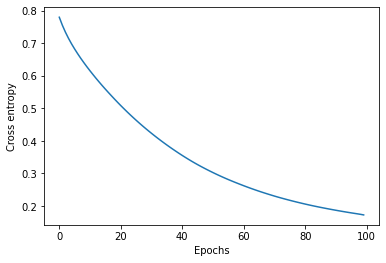

In [174]:
plt.plot(range(len(cost_lst)), cost_lst)
plt.xlabel('Epochs')
plt.ylabel('Cross entropy')
plt.show()

In [193]:
pred_max, pred_indices = torch.max(model(X_train), dim =1)
pred_indices

tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1])

In [195]:
y_train

tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1])

In [197]:
train_pred, train_ind = torch.max(model(X_train), dim =1)
train_acc = torch.mean((train_ind == y_train).float())

test_pred, test_ind = torch.max(model(X_test), dim =1)
test_acc = torch.mean((test_ind == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 92.50
Test Accuracy: 100.00
